In [1]:
# for importing data
import os
import qiime2
import numpy as np
import pandas as pd
from gneiss.util import match
from skbio.stats.ordination import OrdinationResults
from scripts.helper import temporal_plot
from scripts.large_pickle import pickle_dump,pickle_load
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import metadata 
mf = pd.read_csv('../../data/ECAM-Qiita-10249/metadata-matched.tsv',sep='\t',index_col=0)
btdf = pd.read_csv('../../data/ECAM-Qiita-10249/table-matched.tsv',sep='\t',index_col=0)

mf['DA'] = mf['diet'] + ' ' + mf['antiexposedall']

# get pcoa metric types
pcoa_name = {'Bray Curtis':'bray_curtis_pcoa_results.qza',
             'Jaccard':'jaccard_pcoa_results.qza',
             'UniFrac':'gUniFrac_alpha0_pcoa_results.qza',
             'W-UniFrac':'gUniFrac_alpha1_pcoa_results.qza',
             'Aitchison':'aitchison_pcoa_results.qza'}
# emoty dict to fill with tables
pcoa_tables = {}

#get r number PC-dims to store
r = 2
# where output is stored
output_path = '../../data/ECAM-Qiita-10249/q2-analysis/core-metrics-results'
# for each metric and location import the pcoa table
for metric_name,file_name in pcoa_name.items():   
    file_name = os.path.join(output_path,file_name)
    # import OrdinationResults
    pc = qiime2.Artifact.load(file_name).view(OrdinationResults)
    # save r number pc axis 
    pcdf = pc.samples[list(range(r))]
    # also save explained variance
    eigs_ = np.array(sorted(pc.eigvals[list(range(r))].values)[::-1])
    prop_explained = eigs_**2 / np.sum(eigs_**2)
    # prop_explained = pc.proportion_explained[list(range(r))].values
    # match metadata and pc-table along with prop. explained
    pcoa_tables[metric_name] = list(match(mf, pcdf)) + [prop_explained]

# import traj.
CTF_ordination = qiime2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/subject_biplot.qza').view(OrdinationResults)
subject_trajectory = qiime2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/state_subject_ordination.qza').view(pd.DataFrame)
feature_trajectory = qiime2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/state_feature_ordination.qza').view(pd.DataFrame)
# merge
subject_trajectory, pcdf = match(subject_trajectory, mf)
n_comp = 2
pcdf =  subject_trajectory[['PC'+str(i+1) for i in range(n_comp)]] * -1
pcdf.columns = list(range(n_comp))
pcoa_tables['CTF'] = list(match(mf,pcdf)) + [CTF_ordination.proportion_explained.values]


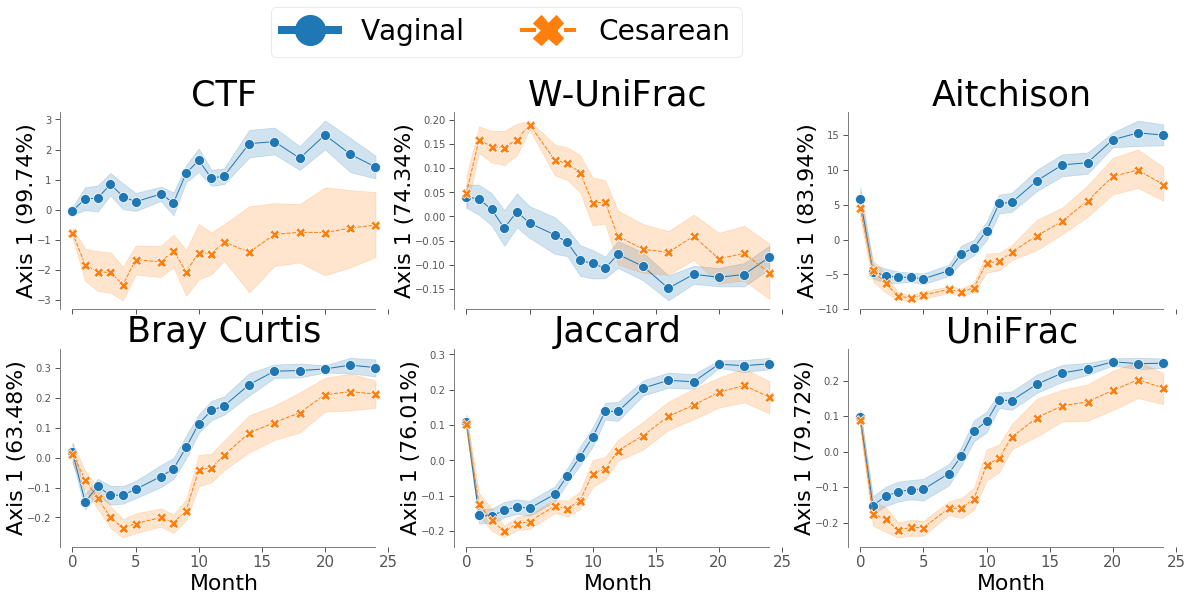

In [3]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 1, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 15 
plt.rcParams['ytick.labelsize'] = 10
i = 0 # iterator for axn
color_by = 'delivery' # colors for the plot
style_by = 'delivery' # markers for the plot

# figure perams
fig,axn = plt.subplots(2,3,figsize=(20,8),
                       sharex=True,
                       sharey=False)
# flatten the axis to easily iterate
axn = axn.flatten()
# for each row in figure
metrics_ = ['CTF', 'W-UniFrac', 'Aitchison',
            'Bray Curtis', 'Jaccard', 'UniFrac']
# for each metric saved -- in each column
for metric_name in metrics_:
    pcmf, pcdf, prop_expl = pcoa_tables[metric_name]
    # Add loadings to metadata for PC axis
    pc_i = 0
    pcmf['loading_tmp'] = pcdf[pc_i].copy()
    # set title 
    if pc_i == 0:
        title = metric_name
        x_label = 'Month'
    else:
        title = ''
        x_label = ''
    # label y-label with % explained    
    y_label = 'Axis %i (%.2f%%)'%(pc_i+1, prop_expl[pc_i]*100)    
    # too few subjects at these months
    pcmf = pcmf[~pcmf.month.isin([6, 15, 19])]
    # plot using the helper
    axn[i] = temporal_plot('month','loading_tmp', pcmf.sort_values(style_by,ascending=False),
                           axn[i], title, x_label, y_label, 35, 22, 22,
                           hue=color_by, style=style_by, ci=68,
                           min_x=0, max_x=24)
    axn[i].set_xlim(-1,25)
    i += 1

# generate legend from last iterations     
handles, labels = axn[i-1].get_legend_handles_labels()
legend = axn[i-1].legend(handles[1:], labels[1:], loc=2, 
                         bbox_to_anchor=(-1.8, 2.8),
                         prop={'size':28},
                         fancybox=True, framealpha=0.5, 
                         ncol=2, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:-1]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[-1:]:
    line.set_linewidth(4.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# save the figure to file
plt.savefig('../../results/ECAM-subjects-loadings.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
    
plt.show()

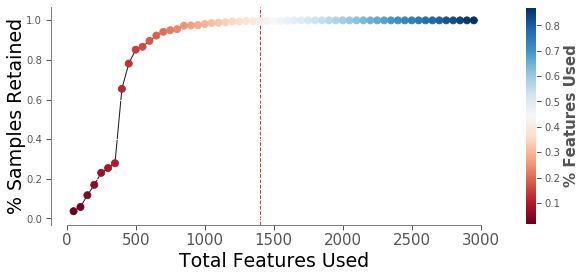

In [4]:
perc_kept = {}
for pi in np.arange(50, 3000, 50):
    pc = 'PC1'
    lr = []
    for month_,mdf  in feature_trajectory.groupby('month'):
        mdf = mdf.set_index('feature_id')
        mdf = mdf.sort_values(pc)
        subids = mf[mf.month.isin([int(month_)])].index
        den_ind = mdf[pc][:pi].index
        num_ind = mdf[pc][-pi:].index     
        num = np.log(btdf.loc[num_ind,subids].sum(axis=0))
        den = np.log(btdf.loc[den_ind,subids].sum(axis=0))
        lr_sub = pd.DataFrame(num - den,columns=['logratio'])
        lr.append(lr_sub)

    lr = pd.concat(lr)
    lr = pd.concat([lr,mf], axis=1, sort=True)
    lr['logratio'][~np.isfinite(lr['logratio'])] = np.nan
    lr = lr.dropna(subset=['logratio'])
    perc_kept[pi] = [lr.shape[0] / btdf.shape[1],
                     pi / btdf.shape[0]]
lr_Ndf = pd.DataFrame(perc_kept, ['percent-sample',
                                  'percent-features']).T

fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(lr_Ndf.index, lr_Ndf['percent-sample'],
        alpha=.9, c='black', zorder=-1)
points = ax.scatter(lr_Ndf.index,
                    lr_Ndf["percent-sample"],
                    c=lr_Ndf["percent-features"],
                    s=50, cmap="RdBu")
cbar = fig.colorbar(points)
cbar.set_label(label='% Features Used',
               size=15,weight='bold')
cbar.ax.tick_params(labelsize=10) 
ax.axvline(1400, c='#e41a1c', ls='--',
           alpha=.9, zorder=-1)

ax.set_xlabel('Total Features Used', color='#000000',
              fontsize=19)
ax.set_ylabel('% Samples Retained', color='#000000',
              fontsize=19, labelpad=0)

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 3000)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
        
# save the figure to file
plt.savefig('../../results/ECAM-lr-N-plot.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

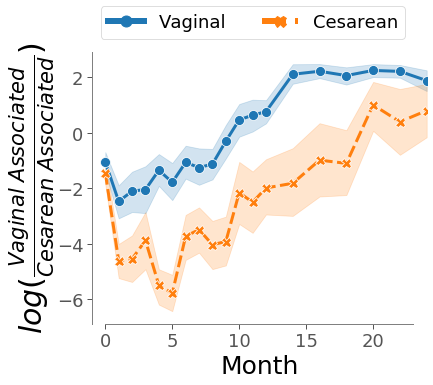

In [5]:
pi = 700
pc = 'PC1'
lr = []
btdfps = btdf.copy()

for month_,mdf  in feature_trajectory.groupby('month'):
    mdf = mdf.set_index('feature_id')
    mdf = mdf.sort_values(pc)
    subids = mf[mf.month.isin([int(month_)])].index
    den_ind = mdf[pc][:pi].index
    num_ind = mdf[pc][-pi:].index     
    num = np.log(btdfps.loc[num_ind,subids].sum(axis=0))
    den = np.log(btdfps.loc[den_ind,subids].sum(axis=0))
    lr_sub = pd.DataFrame(num - den,columns=['logratio'])
    lr.append(lr_sub)

lr = pd.concat(lr)
lr = pd.concat([lr,mf], axis=1, sort=True)
lr['logratio'][~np.isfinite(lr['logratio'])] = np.nan
lr = lr.dropna(subset=['logratio'])

# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18

fig, ax = plt.subplots(1,1,figsize=(6,5))

# plot labels
y_label = '$log(\\frac{Vaginal\,\,Associated}{Cesarean\,\,Associated})$'
x_label = 'Month' 
#title = str(pi)
title = ''

# too few subjects at these months
# due to drop outs in zero counts
lr = lr[~lr.month.isin([15, 19])]
# generate plot
ax = temporal_plot('month','logratio', lr.sort_values('diet'), ax,
                    title, x_label, y_label, 35, 25, 30,
                    hue='delivery', style='delivery', ci=68,
                    min_x=0, max_x=23)
ax.set_xlim(-1,24)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.00, 1.2),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

# save the figure to file
plt.savefig('../../results/ECAM-log-ratio.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

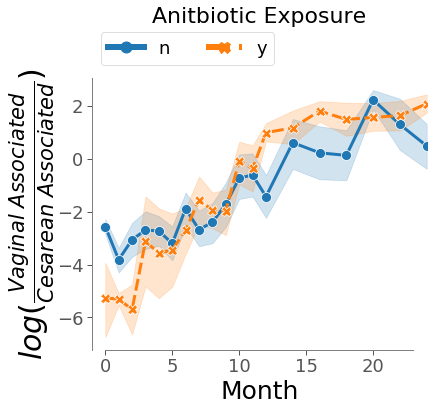

In [27]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18

fig, ax = plt.subplots(1,1,figsize=(6,5))

# plot labels
y_label = '$log(\\frac{Vaginal\,\,Associated}{Cesarean\,\,Associated})$'
x_label = 'Month' 
#title = str(pi)
title = ''

# too few subjects at these months
# due to drop outs in zero counts
lr = lr[~lr.month.isin([15, 19])]
# generate plot
ax = temporal_plot('month','logratio', lr.sort_values('diet'), ax,
                    title, x_label, y_label, 35, 25, 30,
                    hue='antiexposedall',
                    style='antiexposedall', ci=68,
                    min_x=0, max_x=23)
ax.set_xlim(-1,24)
ax.set_title('Anitbiotic Exposure', fontsize=22, y=1.18)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.00, 1.2),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

# save the figure to file
plt.savefig('../../results/ECAM-log-ratio-abx.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

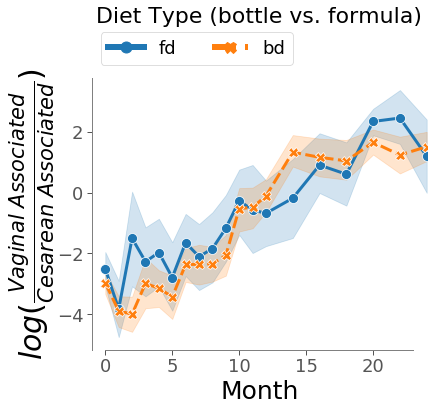

In [30]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 3, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18

fig, ax = plt.subplots(1,1,figsize=(6,5))

# plot labels
y_label = '$log(\\frac{Vaginal\,\,Associated}{Cesarean\,\,Associated})$'
x_label = 'Month' 
#title = str(pi)
title = ''

# too few subjects at these months
# due to drop outs in zero counts
lr = lr[~lr.month.isin([15, 19])]
# generate plot
ax = temporal_plot('month','logratio', lr.sort_values('diet_2', ascending=False), ax,
                    title, x_label, y_label, 35, 25, 30,
                    hue='diet_2',
                    style='diet_2', ci=68,
                    min_x=0, max_x=23)
ax.set_xlim(-1,24)
ax.set_title('Diet Type (bottle vs. formula)', fontsize=22, y=1.18)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':18}, loc=2, 
            bbox_to_anchor=(0.00, 1.2),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

# save the figure to file
plt.savefig('../../results/ECAM-log-ratio-diet.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [5]:
lr.index.name = "#SampleID"
lrq2 = lr.drop(["dna_extracted",
                "mom_ld_abx","mom_prenatal_abx",
                "physical_specimen_remaining"], axis=1)
qiime2.Metadata(lrq2).save('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/log-ratio.tsv')
lrq2.to_csv('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/log-ratio.csv')

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(lrq2.delivery)
lrq2['bmode'] = le.transform(lrq2.delivery)

le.fit(lrq2.host_subject_id)
lrq2['hsid'] = le.transform(lrq2.host_subject_id)

md = smf.mixedlm("logratio ~ bmode * month", lrq2, groups=lrq2["hsid"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: logratio  
No. Observations: 695     Method:             REML      
No. Groups:       44      Scale:              6.6851    
Min. group size:  1       Likelihood:         -1696.0712
Max. group size:  27      Converged:          Yes       
Mean group size:  15.8                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -4.362    0.483 -9.037 0.000 -5.308 -3.416
bmode          2.097    0.641  3.272 0.001  0.841  3.353
month          0.160    0.025  6.395 0.000  0.111  0.209
bmode:month    0.067    0.032  2.131 0.033  0.005  0.129
Group Var      3.279    0.335                           



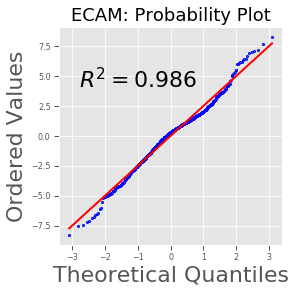

In [7]:
import scipy as sp
             
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8 
plt.rcParams['ytick.labelsize'] = 8

fig, ax = plt.subplots(figsize=(4,4))
_, (__, ___, r) = sp.stats.probplot(mdf.resid, plot=ax, fit=True)
ax.annotate('$R^{2}=%.3f$'%r**2, (-2.8,4),fontsize=22)

ax.get_lines()[0].set_marker('o')
ax.get_lines()[0].set_markerfacecolor('#377eb8')
ax.get_lines()[0].set_markersize(2.0)
ax.get_lines()[1].set_linewidth(2.0)

ax.set_title('ECAM: Probability Plot',fontsize=18)
ax.set_ylabel('Ordered Values',fontsize=22)
ax.set_xlabel('Theoretical Quantiles',fontsize=22)

plt.savefig('../../results/ECAM-lme-resid.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [8]:
mdf.summary().tables[1].to_csv('../../results/ECAM-log-ratio-lme-stats.tsv')
mdf.summary().tables[1]


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-4.362,0.483,-9.037,0.000,-5.308,-3.416
bmode,2.097,0.641,3.272,0.001,0.841,3.353
month,0.160,0.025,6.395,0.000,0.111,0.209
bmode:month,0.067,0.032,2.131,0.033,0.005,0.129
Group Var,3.279,0.335,,,,
